<a href="https://colab.research.google.com/github/efazel/VaR-CVaR/blob/master/VaR_CVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value-at-Risk and Expected Shortfall
by Ehsan Fazel

For a given portfolio, time horizon, and probability, value-at-risk (hereafter VaR) calculates the potential loss given normal market conditions. In a similar vein as VaR, the expected shortfall is the average of all possible losses that are more extreme than VaR. Expected shortfall is also called conditional VaR or CVaR. 

To measure VaR, we use one-sided confidence intervals since we are interested in extreme negative events that take place in the left tail of the distribution. 

Let $R$, $\alpha$, and $h$ be a random variable, a quantile of the distribution function of $R$, and a time horizon, respectively. We have the following:

$$ VaR_{h}(\alpha) = - r \tag{1}$$

where

$$r \in \mathbb{R}: P(R \leq r) = \alpha \tag{2}$$ 

The above expression simply states that the VaR is the $\alpha$ quantile of the distribution of returns. To define expected shortfall:

$$ES_{h}(\alpha) = E[R|R \leq VaR_{h}(\alpha)] \tag{3}$$

Let us demonstrate the definitions in a graph. We need to download a return series and plot the probability distribution in a histogram.

In [ ]:
# For Jupyter notebooks to align the graphs in the middle (you can skip this!)
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr
import datetime as dt
import fix_yahoo_finance as yf
yf.pdr_override()

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


[*********************100%***********************]  1 of 1 downloaded
1-day VaR at 95% confidence level: -0.04249
1-day expected shortfall at 95% confidence level: -0.065235


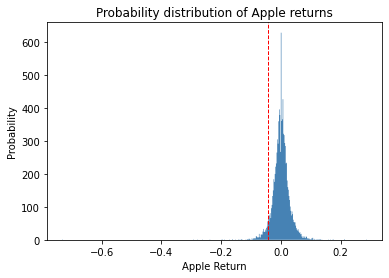

In [3]:
# Download the daily price series of Apple from Yahoo Finance:
start_date = dt.datetime(1980,1,1)
end_date = dt.datetime(2020,1,1)
apple_inc = pdr.get_data_yahoo('AAPL', start_date, end_date)

# Compute returns:
apple_inc['Log_Return_aapl'] = np.log(apple_inc['Adj Close']) - np.log(apple_inc['Adj Close'].shift(1))

# Plot returns:
apple_inc['Log_Return_aapl'].plot.hist(bins=500, alpha=1, histtype='stepfilled', color='steelblue', edgecolor='none');

# Alpha:
alpha = 0.05

# Compute VaR and expected shortfall and round it to 6 decimals:
VaR_aapl = np.round(apple_inc['Log_Return_aapl'].quantile(alpha),6);
ES_aapl = np.round(apple_inc.loc[apple_inc['Log_Return_aapl'] < apple_inc['Log_Return_aapl'].quantile(alpha), 'Log_Return_aapl'].mean(), 6)

# Mark VaR:
plt.axvline(x = VaR_aapl, linestyle='--', linewidth=1, label="VaR", c='red');
plt.xlabel('Apple Return')
plt.ylabel('Probability')
plt.title('Probability distribution of Apple returns')

print('1-day VaR at 95% confidence level: ' + str(VaR_aapl))
print('1-day expected shortfall at 95% confidence level: ' + str(ES_aapl))

The red dashed line corresponds to VaR and the mean of the return valus to the left of the dashed line is the expected shortfall. Moving forward with a stock market index, we consider S&P 500 as a proxy of all the stocks available in the equity market. 

There are many approaches to obtain VaR and expected shortfall in the literature. In this document we consider the following:




*   Using the hitorical data
*   Simulating normal returns from estimated moments of the data
*   Drawing IID simulation from empirical distribution of the data
*   Performing simulation from the estimated student-t distribution by MLE





## Hitorical Data

In [4]:
# Download the data from Yahoo Finance:
start_date = dt.datetime(1980, 1, 1)
end_date = dt.datetime(2018, 1, 1)
sp = pdr.get_data_yahoo('^GSPC', start_date, end_date)

[*********************100%***********************]  1 of 1 downloaded


In [5]:
# Calculate the log-return and examine the data:
sp['Log_Return'] = np.log(sp['Adj Close']) - np.log(sp['Adj Close'].shift(1))
sp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9584 entries, 1980-01-02 to 2017-12-29
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        9584 non-null   float64
 1   High        9584 non-null   float64
 2   Low         9584 non-null   float64
 3   Close       9584 non-null   float64
 4   Adj Close   9584 non-null   float64
 5   Volume      9584 non-null   int64  
 6   Log_Return  9583 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 599.0 KB


In [6]:
# Calculate mean and standard deviation of the data
mu = np.round(np.mean(sp['Log_Return']), 6)
sig = np.round(np.std(sp['Log_Return']), 6)
print('The return is normally distributed with mean ' + str(mu) + ' ' + 'and the standard deviation of ' + str(sig))

The return is normally distributed with mean 0.000337 and the standard deviation of 0.011058


1-day VaR at the 95% confidence level: -0.016335
1-day Expected Shortfall at the 95% confidence level: -0.025921


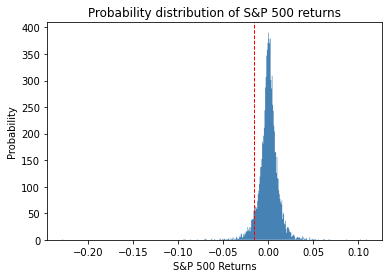

In [7]:
# Plot:
sp['Log_Return'].plot.hist(bins = 500, histtype='stepfilled', color='steelblue', edgecolor='none');
plt.title('Probability distribution of S&P 500 returns')

# VaR and ES:
VaR = np.round(sp['Log_Return'].quantile(0.05),6)
ES = np.round(sp.loc[sp['Log_Return'] < sp['Log_Return'].quantile(0.05), 'Log_Return'].mean(), 6)

# Mark VaR
plt.axvline(x = VaR, linestyle='--', linewidth=1, label="VaR", c='red');
plt.xlabel('S&P 500 Returns')
plt.ylabel('Probability')
plt.title('Probability distribution of S&P 500 returns')

print('1-day VaR at the 95% confidence level: ' + str(VaR))
print('1-day Expected Shortfall at the 95% confidence level: ' + str(ES))

## Simulate Normal Returns

1-day VaR at 95% confidence level: -0.017714
1-day Expected Shortfall at 95% confidence level: -0.022137


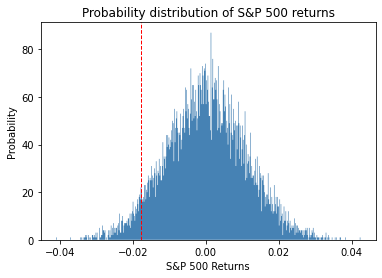

In [8]:
# Simulate normal distribution with the same mean and variance as the data:
np.random.seed(0)
sim = np.random.normal(mu, sig, 10000)

# Plot:
plt.hist(sim, bins=500, alpha=1, histtype='stepfilled', color='steelblue', edgecolor='none');

# VaR and ES:
VaR = np.round(np.percentile(sim, 5), 6)
ES = np.round(np.mean(sim[sim < np.percentile(sim, 5)]),6)

# Mark VaR
plt.axvline(x = VaR, linestyle='--', linewidth=1, label="VaR", c='red');
plt.xlabel('S&P 500 Returns')
plt.ylabel('Probability')
plt.title('Probability distribution of S&P 500 returns')

print('1-day VaR at 95% confidence level: ' + str(VaR))
print('1-day Expected Shortfall at 95% confidence level: ' + str(ES))

## IID Simulation From the Empirical Distribution

To set aside the normality assumption, one can consider the dats itself. Here, we are presenting the results for random draw with replacement from the data.

1-day VaR at 95% confidence level: -0.016379
1-day Expected Shortfall at 95% confidence level: -0.026189


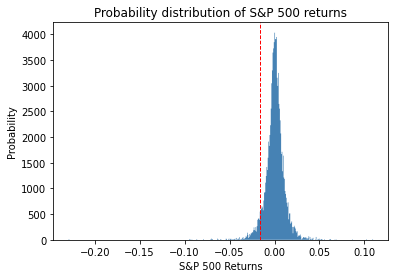

In [9]:
import random 

# Draw 100,000 sample with replacement:
rvec = np.array(random.choices(sp['Log_Return'].iloc[1:], k = 100000)) #do not select the first NaN# 

#plt.hist(rvec, bins=500, alpha=1, histtype='stepfilled', color='steelblue', edgecolor='none');
plt.hist(rvec, bins=500, alpha=1, histtype='stepfilled', color='steelblue', edgecolor='none');

# VaR and ES:
VaR = np.round(np.percentile(rvec, 5), 6)
ES = np.round(np.mean(rvec[rvec < np.percentile(rvec, 5)]),6)

# Mark VaR
plt.axvline(x = VaR, linestyle='--', linewidth=1, label="VaR", c='red');
plt.xlabel('S&P 500 Returns')
plt.ylabel('Probability')
plt.title('Probability distribution of S&P 500 returns')

print('1-day VaR at 95% confidence level: ' + str(VaR))
print('1-day Expected Shortfall at 95% confidence level: ' + str(ES))

## Examine the Normality Assumption

Let us compute higher moments (skewness and kurtosis) and use QQ-plots to examine the normality assumption that we imposed in the previous sections.

In [10]:
# Import skew and kurtosis:
from scipy.stats import skew, kurtosis  

skw = skew(sp['Log_Return'].iloc[1:])
krt = kurtosis(sp['Log_Return'].iloc[1:])
print('Skewness: ' + str(np.round(skw, 6)))
print('Kurtosis: ' + str(np.round(krt, 6)))

Skewness: -1.162985
Kurtosis: 27.087823


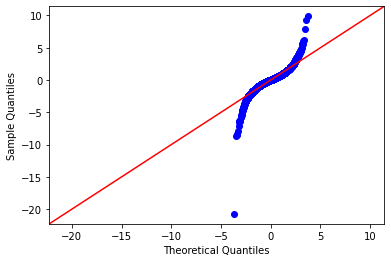

In [12]:
# Import QQ-plots:
from statsmodels.graphics.gofplots import qqplot
qqplot(sp['Log_Return'].iloc[1:], fit=True, line='45');

There is ample evidence against the normality of returns: skewness is negative, kurtosis implies fat tails, and the quantiles do not sit on the 45 degree line 

## Simulation from the Estimated Student-t

In [13]:
# Import stats:
from scipy import stats

# Estimate degrees of freedom, standard deviation, and the mean, assuming student-t distribution:
df, mu_t, sig_t = stats.t.fit(sp['Log_Return'].iloc[1:])

In [14]:
# Define a function to generate student-t data:
# Reference: courtesy of John D. Cook https://www.johndcook.com/python_student_t_rng.html 

import math

def student_t_generator(mu_t, sig_t, nu):
  random_number = random.gauss(mu_t, sig_t)
  x = random.gauss(mu_t, sig_t)
  y = 2.0*random.gammavariate(0.5*nu, 2.0)

  return x / (math.sqrt(y/nu))

In [15]:
# Simulate from student-t 100,000 random returns:
dim = 100000
sim_t_vec = np.zeros(dim,)

for i in range(dim):
  gen = student_t_generator(mu_t, sig_t, df)
  sim_t_vec[i] = gen

1-day VaR at 95% confidence level: -0.010573
1-day Expected Shortfall at 95% confidence level: -0.017451


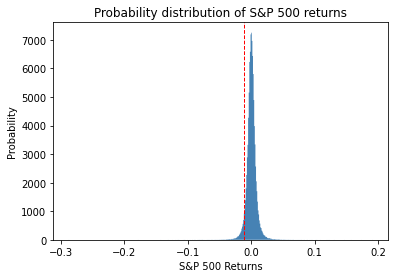

In [16]:
# Plot the distribution:
plt.hist(sim_t_vec, bins=500, alpha=1, histtype='stepfilled', color='steelblue', edgecolor='none');

# VaR and ES:
VaR = np.round(np.percentile(sim_t_vec, 5), 6)
ES = np.round(np.mean(sim_t_vec[sim_t_vec < np.percentile(sim_t_vec, 5)]),6)

# Mark VaR
plt.axvline(x = VaR, linestyle='--', linewidth=1, label="VaR", c='red');
plt.xlabel('S&P 500 Returns')
plt.ylabel('Probability')
plt.title('Probability distribution of S&P 500 returns')


print('1-day VaR at 95% confidence level: ' + str(VaR))
print('1-day Expected Shortfall at 95% confidence level: ' + str(ES))

## Multiple Horizon (10 days) VaR and ES

In this section we are going to repeat what we did for multiple horizons. Since we are using log of returns, we can simply add them to get the return of a period that covers the horizon.





In [17]:
# Simulate from student-t:

# Alpha probability:
alpha = 5

# Dimension of the vector
dim = 100000

# Time horizon
h = 10

sim_t_vec = np.zeros(dim,)

for i in range(dim):
  sim_t_vec_initial = 0
  for j in range(h):
    sim_t_vec_initial = sim_t_vec_initial + student_t_generator(mu_t, sig_t, df)
    sim_t_vec[i] = sim_t_vec_initial

1-day VaR at 95% confidence level: -0.034176
1-day Expected Shortfall at 95% confidnce level: -0.049494


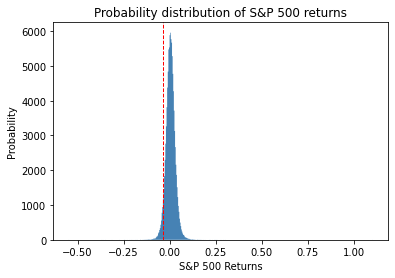

In [18]:
# Plot
plt.hist(sim_t_vec, bins=500, alpha=1, histtype='stepfilled', color='steelblue', edgecolor='none');

VaR = np.round(np.percentile(sim_t_vec, alpha), 6)
ES = np.round(np.mean(sim_t_vec[sim_t_vec < np.percentile(sim_t_vec, alpha)]),6)

# Mark VaR
plt.axvline(x = VaR, linestyle='--', linewidth=1, label="VaR", c='red');
plt.xlabel('S&P 500 Returns')
plt.ylabel('Probability')
plt.title('Probability distribution of S&P 500 returns')

print('1-day VaR at 95% confidence level: ' + str(VaR))
print('1-day Expected Shortfall at 95% confidnce level: ' + str(ES))

In [19]:
# simulate from the empirical distribution with iid draws

# Alpha probability:
alpha = 5

# Dimension of the vector
dim = 100000

# Time horizon
h = 10

sim_emp_vec_initial = 0
for j in range(h):
  sim_emp_vec_initial = sim_emp_vec_initial + np.array(random.choices(sp['Log_Return'].iloc[1:], k = 100000))
  sim_emp_vec = sim_emp_vec_initial

1-day VaR at 95% confidence level: -0.052994
1-day Expected Shortfall at 95% confidnce level: -0.075351


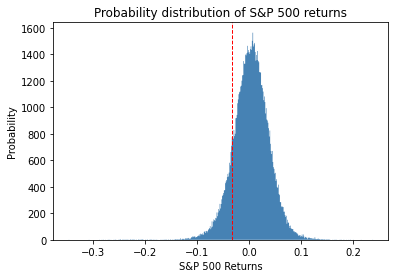

In [20]:
plt.hist(sim_emp_vec, bins=500, alpha=1, histtype='stepfilled', color='steelblue', edgecolor='none');

# Mark VaR
plt.axvline(x = VaR, linestyle='--', linewidth=1, label="VaR", c='red');
plt.xlabel('S&P 500 Returns')
plt.ylabel('Probability')
plt.title('Probability distribution of S&P 500 returns')

# VaR and Expected Shortfall:
VaR = np.round(np.percentile(sim_emp_vec, alpha), 6)
ES = np.round(np.mean(sim_emp_vec[sim_emp_vec < np.percentile(sim_emp_vec, alpha)]),6)

print('1-day VaR at 95% confidence level: ' + str(VaR))
print('1-day Expected Shortfall at 95% confidnce level: ' + str(ES))